In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
project_name = 'face'

In [ ]:
!pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [3]:
!pip install opendatasets --upgrade

In [3]:
cd /content/drive/MyDrive/gan


/content/drive/MyDrive/gan


In [60]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/celeba-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./celeba-dataset" (use force=True to force download)


In [8]:
import os

data_dir='/content/drive/MyDrive/gan/animefacedataset'
print(os.listdir(data_dir))

['images']


In [12]:
import os
import random

# Path to the folder containing images
folder_path = '/content/drive/MyDrive/gan/animefacedataset/images'

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.gif'))]

# Check if there are more than 100 images
if len(image_files) > 1000:
    # Randomly select 100 images to keep
    images_to_keep = random.sample(image_files, 1000)

    # Delete the rest of the images
    for image in image_files:
        if image not in images_to_keep:
            os.remove(os.path.join(folder_path, image))
    print(f"Deleted")
else:
    print("Folder contains 100 or fewer images. No images were deleted.")

Deleted


In [13]:
print(os.listdir(data_dir+'/images')[:10])

['10392_2004.jpg', '10413_2004.jpg', '10533_2005.jpg', '10622_2005.jpg', '10645_2005.jpg', '10665_2005.jpg', '10675_2005.jpg', '10696_2005.jpg', '10706_2005.jpg', '10708_2005.jpg']


In [14]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [15]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [16]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


In [19]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

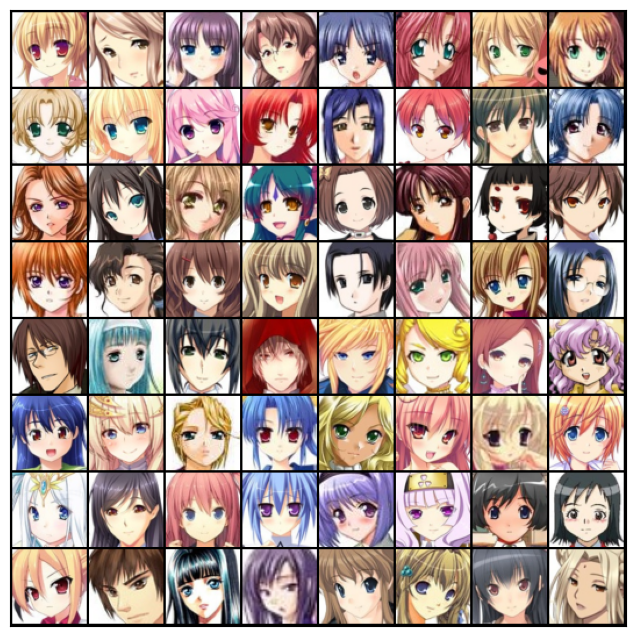

In [20]:
show_batch(train_dl)

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)

In [24]:
import torch.nn as nn

In [25]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [26]:
discriminator = to_device(discriminator, device)

In [27]:
latent_size = 128

In [28]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


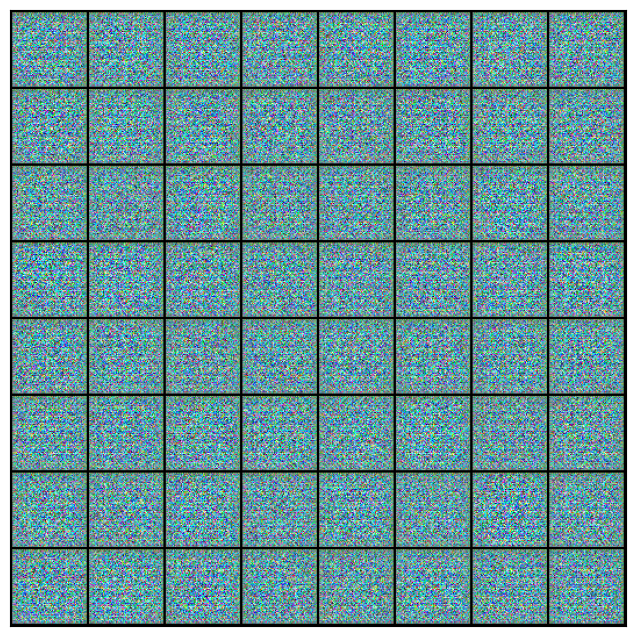

In [29]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [30]:
generator = to_device(generator, device)

In [31]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [32]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [33]:
from torchvision.utils import save_image

In [34]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [35]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [36]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


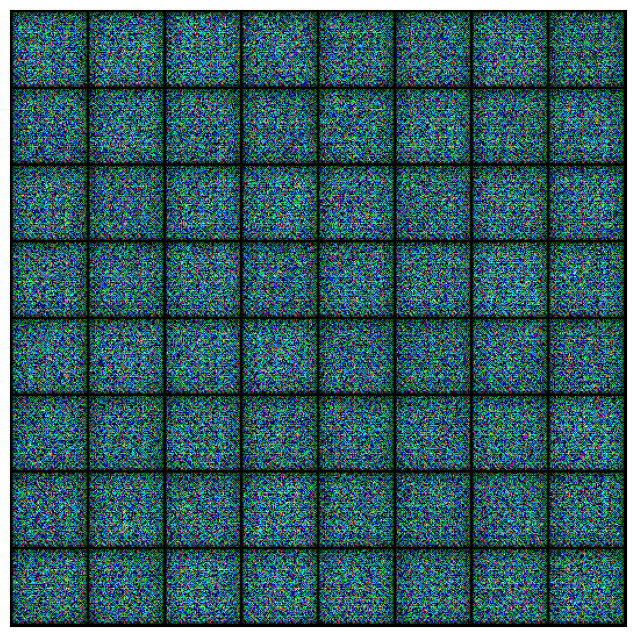

In [37]:
save_samples(0, fixed_latent)

In [38]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [39]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [49]:
lr = 0.0002
epochs = 100

In [50]:
history = fit(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 10.8666, loss_d: 1.4467, real_score: 0.9082, fake_score: 0.6601
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 5.2763, loss_d: 0.9296, real_score: 0.7667, fake_score: 0.3787
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 3.8244, loss_d: 0.5341, real_score: 0.7825, fake_score: 0.2124
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.9980, loss_d: 0.3550, real_score: 0.9096, fake_score: 0.2058
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.2980, loss_d: 0.4322, real_score: 0.7729, fake_score: 0.0856
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 3.3000, loss_d: 0.4769, real_score: 0.7410, fake_score: 0.0890
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.4262, loss_d: 0.7435, real_score: 0.5983, fake_score: 0.0540
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 3.8647, loss_d: 0.9483, real_score: 0.4672, fake_score: 0.0174
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 5.0123, loss_d: 1.7997, real_score: 0.2257, fake_score: 0.0039
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 6.1802, loss_d: 1.0172, real_score: 0.8363, fake_score: 0.5188
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.2263, loss_d: 0.4327, real_score: 0.8187, fake_score: 0.1742
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 6.2419, loss_d: 0.6151, real_score: 0.8783, fake_score: 0.3329
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 5.0956, loss_d: 0.7219, real_score: 0.5999, fake_score: 0.0252
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.3836, loss_d: 0.4892, real_score: 0.7768, fake_score: 0.1632
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 6.6808, loss_d: 1.6099, real_score: 0.8982, fake_score: 0.7437
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.2307, loss_d: 0.5648, real_score: 0.7807, fake_score: 0.2063
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.7807, loss_d: 0.6486, real_score: 0.9361, fake_score: 0.3919
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.3508, loss_d: 0.6802, real_score: 0.5954, fake_score: 0.0804
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.9340, loss_d: 0.7528, real_score: 0.5514, fake_score: 0.0490
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 2.7323, loss_d: 0.6342, real_score: 0.7626, fake_score: 0.2580
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 7.5723, loss_d: 1.5552, real_score: 0.9019, fake_score: 0.7234
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.9156, loss_d: 0.6265, real_score: 0.8750, fake_score: 0.3666
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.1135, loss_d: 0.9131, real_score: 0.4721, fake_score: 0.0402
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.4570, loss_d: 0.3007, real_score: 0.8691, fake_score: 0.1222
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.5364, loss_d: 0.6799, real_score: 0.6078, fake_score: 0.0214
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.8141, loss_d: 0.5065, real_score: 0.7627, fake_score: 0.1693
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.2767, loss_d: 0.8483, real_score: 0.6282, fake_score: 0.1653
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.9671, loss_d: 0.6719, real_score: 0.7763, fake_score: 0.2929
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.8009, loss_d: 0.5047, real_score: 0.8403, fake_score: 0.2518
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.9775, loss_d: 0.4427, real_score: 0.9025, fake_score: 0.2674
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.0198, loss_d: 1.4014, real_score: 0.3210, fake_score: 0.0104
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.3341, loss_d: 0.6585, real_score: 0.6813, fake_score: 0.1486
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.5138, loss_d: 0.6584, real_score: 0.9046, fake_score: 0.3897
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 4.0739, loss_d: 0.4403, real_score: 0.7889, fake_score: 0.1355
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 5.6547, loss_d: 0.6657, real_score: 0.5936, fake_score: 0.0193
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.4491, loss_d: 0.6345, real_score: 0.6674, fake_score: 0.1149
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 6.3057, loss_d: 0.7551, real_score: 0.8225, fake_score: 0.3817
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 6.8782, loss_d: 1.0691, real_score: 0.9710, fake_score: 0.6084
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.2873, loss_d: 0.4884, real_score: 0.7579, fake_score: 0.1491
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 5.3347, loss_d: 0.3760, real_score: 0.8542, fake_score: 0.1665
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.3669, loss_d: 0.7395, real_score: 0.5903, fake_score: 0.0864
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.0595, loss_d: 1.7748, real_score: 0.2576, fake_score: 0.0138
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 7.4295, loss_d: 0.8262, real_score: 0.9369, fake_score: 0.4874
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.9867, loss_d: 0.9497, real_score: 0.4683, fake_score: 0.0276
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.7133, loss_d: 0.7652, real_score: 0.8969, fake_score: 0.4341
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 7.3952, loss_d: 0.6307, real_score: 0.9534, fake_score: 0.4036
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.8727, loss_d: 0.5483, real_score: 0.8120, fake_score: 0.2479
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 4.1856, loss_d: 0.6755, real_score: 0.8513, fake_score: 0.3458
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 3.9079, loss_d: 0.5617, real_score: 0.7682, fake_score: 0.2118
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 5.1752, loss_d: 0.4933, real_score: 0.8987, fake_score: 0.2977
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.7547, loss_d: 0.7101, real_score: 0.5706, fake_score: 0.0110
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.8033, loss_d: 0.6684, real_score: 0.6251, fake_score: 0.0908
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 5.2275, loss_d: 0.6583, real_score: 0.8908, fake_score: 0.3857
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 7.4437, loss_d: 0.9511, real_score: 0.8639, fake_score: 0.5127
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 5.3444, loss_d: 0.5535, real_score: 0.8332, fake_score: 0.2601
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.5510, loss_d: 0.2531, real_score: 0.8707, fake_score: 0.0883
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.8374, loss_d: 0.4729, real_score: 0.7202, fake_score: 0.0710
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.5062, loss_d: 2.3879, real_score: 0.1478, fake_score: 0.0030
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.2987, loss_d: 0.6657, real_score: 0.7264, fake_score: 0.2356
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.4117, loss_d: 0.4502, real_score: 0.7374, fake_score: 0.0726
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.9763, loss_d: 0.8753, real_score: 0.8822, fake_score: 0.4749
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 5.2248, loss_d: 0.6629, real_score: 0.8424, fake_score: 0.3332
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.5782, loss_d: 0.3852, real_score: 0.7589, fake_score: 0.0541
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 5.5553, loss_d: 1.8864, real_score: 0.2169, fake_score: 0.0032
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 5.3842, loss_d: 0.6056, real_score: 0.8675, fake_score: 0.3329
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.4610, loss_d: 0.7398, real_score: 0.5709, fake_score: 0.0232
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 5.6579, loss_d: 0.7148, real_score: 0.9641, fake_score: 0.4644
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.1837, loss_d: 0.3819, real_score: 0.7807, fake_score: 0.1001
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 6.9578, loss_d: 0.8377, real_score: 0.9755, fake_score: 0.5218
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.4484, loss_d: 0.4577, real_score: 0.8074, fake_score: 0.1881
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 5.8866, loss_d: 0.3690, real_score: 0.7359, fake_score: 0.0109
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 6.6708, loss_d: 0.7544, real_score: 0.8648, fake_score: 0.4072
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 5.9256, loss_d: 0.5084, real_score: 0.8841, fake_score: 0.2996
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 7.7668, loss_d: 1.4578, real_score: 0.9428, fake_score: 0.7191
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.4367, loss_d: 0.4423, real_score: 0.8681, fake_score: 0.2328
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 4.3706, loss_d: 0.3153, real_score: 0.8364, fake_score: 0.1033
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 8.0828, loss_d: 1.0274, real_score: 0.9724, fake_score: 0.5965
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.7090, loss_d: 0.2929, real_score: 0.8559, fake_score: 0.1081
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.0458, loss_d: 1.0186, real_score: 0.4370, fake_score: 0.0093
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.2307, loss_d: 0.4874, real_score: 0.7375, fake_score: 0.1183
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.3149, loss_d: 0.7169, real_score: 0.5629, fake_score: 0.0293
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 6.7122, loss_d: 0.7302, real_score: 0.9429, fake_score: 0.4573
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 5.3030, loss_d: 0.5312, real_score: 0.8098, fake_score: 0.2410
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 6.3864, loss_d: 0.1909, real_score: 0.8618, fake_score: 0.0249
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 6.6665, loss_d: 0.6611, real_score: 0.9612, fake_score: 0.4357
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.8277, loss_d: 0.4171, real_score: 0.7716, fake_score: 0.1070
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.4826, loss_d: 0.2181, real_score: 0.8457, fake_score: 0.0288
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 5.5915, loss_d: 0.5169, real_score: 0.8765, fake_score: 0.2889
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 4.3681, loss_d: 0.4655, real_score: 0.8358, fake_score: 0.2253
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 3.7485, loss_d: 0.4279, real_score: 0.7502, fake_score: 0.0862
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.8392, loss_d: 0.4934, real_score: 0.9256, fake_score: 0.3058
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.5957, loss_d: 0.4318, real_score: 0.7115, fake_score: 0.0446
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 6.0892, loss_d: 0.4635, real_score: 0.9065, fake_score: 0.2839
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 8.8336, loss_d: 0.7704, real_score: 0.9462, fake_score: 0.4862
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.0605, loss_d: 0.2007, real_score: 0.9252, fake_score: 0.1080
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 7.0573, loss_d: 0.5353, real_score: 0.9058, fake_score: 0.3152
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 4.3774, loss_d: 0.5690, real_score: 0.7355, fake_score: 0.1772
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 3.7699, loss_d: 0.2390, real_score: 0.9084, fake_score: 0.1170
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 6.8819, loss_d: 0.5771, real_score: 0.8667, fake_score: 0.3224
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 8.3922, loss_d: 1.1820, real_score: 0.9288, fake_score: 0.5801
Saving generated-images-0100.png


In [45]:
losses_g, losses_d, real_scores, fake_scores = history

In [46]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [52]:
generator.load_state_dict(torch.load('G.pth'))
discriminator.load_state_dict(torch.load('D.pth'))

<ipython-input-52-c5bc4581663f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('G.pth'))
<ipython-input-52-c5bc4581663f>:2: FutureWarn

<All keys matched successfully>

In [53]:
generator.train()
discriminator.train()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [54]:
start_epoch = 101  # Resuming from epoch 100
num_epochs = 200

In [55]:
import torch
from tqdm import tqdm

# Function to train the GAN
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Load the previously saved generator and discriminator state_dicts
    generator.load_state_dict(torch.load('G.pth'))
    discriminator.load_state_dict(torch.load('D.pth'))

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers (you can also load optimizer state_dicts if saved)
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # You can load optimizer states if you saved them earlier
    # opt_g.load_state_dict(torch.load('optimizer_G.pth'))
    # opt_d.load_state_dict(torch.load('optimizer_D.pth'))

    # Start training from the specified epoch (e.g., 101 for resuming)
    for epoch in range(start_idx, epochs + start_idx):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (for the last batch of the current epoch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch, epochs + start_idx - 1, loss_g, loss_d, real_score, fake_score))

        # Save generated samples from the generator
        save_samples(epoch, fixed_latent, show=False)

        # Optionally, save the model's state every 10 epochs or so
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), 'G.pth')
            torch.save(discriminator.state_dict(), 'D.pth')
            # Optionally save optimizer states
            # torch.save(opt_g.state_dict(), 'optimizer_G.pth')
            # torch.save(opt_d.state_dict(), 'optimizer_D.pth')

    return losses_g, losses_d, real_scores, fake_scores


In [56]:
losses_g, losses_d, real_scores, fake_scores = fit(100, lr=0.0002, start_idx=101)


<ipython-input-55-0ca2539e51e4>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('G.pth'))
<ipython-input-55-0ca2539e51e4>:10: FutureWar

Epoch [101/200], loss_g: 5.9027, loss_d: 0.5534, real_score: 0.7843, fake_score: 0.1369
Saving generated-images-0101.png


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch [102/200], loss_g: 5.1614, loss_d: 0.9521, real_score: 0.6001, fake_score: 0.1183
Saving generated-images-0102.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [103/200], loss_g: 4.7514, loss_d: 0.4067, real_score: 0.8411, fake_score: 0.1751
Saving generated-images-0103.png


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch [104/200], loss_g: 5.5715, loss_d: 0.5627, real_score: 0.6619, fake_score: 0.0224
Saving generated-images-0104.png


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch [105/200], loss_g: 3.7079, loss_d: 0.4456, real_score: 0.8311, fake_score: 0.1772
Saving generated-images-0105.png


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch [106/200], loss_g: 2.2136, loss_d: 0.2824, real_score: 0.8530, fake_score: 0.0760
Saving generated-images-0106.png


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch [107/200], loss_g: 3.5909, loss_d: 0.9452, real_score: 0.4731, fake_score: 0.0169
Saving generated-images-0107.png


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Epoch [108/200], loss_g: 4.8964, loss_d: 0.5919, real_score: 0.8417, fake_score: 0.2944
Saving generated-images-0108.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [109/200], loss_g: 5.1339, loss_d: 0.3222, real_score: 0.8058, fake_score: 0.0499
Saving generated-images-0109.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [110/200], loss_g: 3.0524, loss_d: 1.3885, real_score: 0.3292, fake_score: 0.0240
Saving generated-images-0110.png


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch [111/200], loss_g: 3.4033, loss_d: 0.6074, real_score: 0.7480, fake_score: 0.2180
Saving generated-images-0111.png


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch [112/200], loss_g: 5.5802, loss_d: 1.6127, real_score: 0.8537, fake_score: 0.7072
Saving generated-images-0112.png


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch [113/200], loss_g: 4.0427, loss_d: 0.6686, real_score: 0.6803, fake_score: 0.1855
Saving generated-images-0113.png


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [114/200], loss_g: 2.7680, loss_d: 1.6254, real_score: 0.3022, fake_score: 0.0288
Saving generated-images-0114.png


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch [115/200], loss_g: 5.2083, loss_d: 0.8287, real_score: 0.8179, fake_score: 0.4286
Saving generated-images-0115.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [116/200], loss_g: 2.2049, loss_d: 1.0763, real_score: 0.4570, fake_score: 0.0885
Saving generated-images-0116.png


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Epoch [117/200], loss_g: 5.4645, loss_d: 1.1675, real_score: 0.8149, fake_score: 0.5673
Saving generated-images-0117.png


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Epoch [118/200], loss_g: 3.4279, loss_d: 0.7141, real_score: 0.8514, fake_score: 0.3939
Saving generated-images-0118.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [119/200], loss_g: 3.2963, loss_d: 0.5198, real_score: 0.8640, fake_score: 0.2834
Saving generated-images-0119.png


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch [120/200], loss_g: 3.9794, loss_d: 0.4751, real_score: 0.7526, fake_score: 0.1328
Saving generated-images-0120.png


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch [121/200], loss_g: 4.6043, loss_d: 0.3234, real_score: 0.8524, fake_score: 0.1322
Saving generated-images-0121.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [122/200], loss_g: 1.7963, loss_d: 2.3057, real_score: 0.1603, fake_score: 0.0052
Saving generated-images-0122.png


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch [123/200], loss_g: 3.4940, loss_d: 0.4657, real_score: 0.7353, fake_score: 0.0798
Saving generated-images-0123.png


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch [124/200], loss_g: 3.5495, loss_d: 0.5700, real_score: 0.9271, fake_score: 0.3409
Saving generated-images-0124.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [125/200], loss_g: 2.1875, loss_d: 0.7523, real_score: 0.6066, fake_score: 0.0950
Saving generated-images-0125.png


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [126/200], loss_g: 1.9227, loss_d: 1.2364, real_score: 0.3968, fake_score: 0.0232
Saving generated-images-0126.png


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch [127/200], loss_g: 2.9235, loss_d: 0.3643, real_score: 0.8502, fake_score: 0.1651
Saving generated-images-0127.png


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch [128/200], loss_g: 5.1056, loss_d: 0.7029, real_score: 0.8689, fake_score: 0.3791
Saving generated-images-0128.png


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Epoch [129/200], loss_g: 1.5102, loss_d: 1.0607, real_score: 0.4784, fake_score: 0.0506
Saving generated-images-0129.png


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch [130/200], loss_g: 4.1107, loss_d: 0.4525, real_score: 0.8861, fake_score: 0.2623
Saving generated-images-0130.png


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch [131/200], loss_g: 5.3690, loss_d: 0.8556, real_score: 0.8863, fake_score: 0.4737
Saving generated-images-0131.png


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch [132/200], loss_g: 2.6225, loss_d: 0.2518, real_score: 0.8725, fake_score: 0.0869
Saving generated-images-0132.png


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch [133/200], loss_g: 2.6640, loss_d: 0.9001, real_score: 0.5049, fake_score: 0.0462
Saving generated-images-0133.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [134/200], loss_g: 2.3579, loss_d: 0.8008, real_score: 0.5681, fake_score: 0.0735
Saving generated-images-0134.png


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch [135/200], loss_g: 2.3429, loss_d: 0.7790, real_score: 0.5650, fake_score: 0.0744
Saving generated-images-0135.png


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch [136/200], loss_g: 3.7941, loss_d: 0.7726, real_score: 0.7269, fake_score: 0.2945
Saving generated-images-0136.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [137/200], loss_g: 7.4598, loss_d: 1.1082, real_score: 0.9649, fake_score: 0.6141
Saving generated-images-0137.png


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch [138/200], loss_g: 5.8831, loss_d: 0.6869, real_score: 0.8968, fake_score: 0.4090
Saving generated-images-0138.png


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch [139/200], loss_g: 2.2190, loss_d: 0.3130, real_score: 0.8609, fake_score: 0.1288
Saving generated-images-0139.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [140/200], loss_g: 4.3746, loss_d: 0.5997, real_score: 0.7976, fake_score: 0.2764
Saving generated-images-0140.png


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch [141/200], loss_g: 4.9317, loss_d: 0.8626, real_score: 0.9182, fake_score: 0.4767
Saving generated-images-0141.png


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Epoch [142/200], loss_g: 7.2175, loss_d: 0.6395, real_score: 0.9057, fake_score: 0.3829
Saving generated-images-0142.png


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch [143/200], loss_g: 6.4418, loss_d: 0.8081, real_score: 0.9591, fake_score: 0.5000
Saving generated-images-0143.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [144/200], loss_g: 6.2305, loss_d: 0.9470, real_score: 0.9281, fake_score: 0.5239
Saving generated-images-0144.png


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch [145/200], loss_g: 3.0672, loss_d: 0.7725, real_score: 0.5584, fake_score: 0.0633
Saving generated-images-0145.png


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch [146/200], loss_g: 5.1851, loss_d: 0.5590, real_score: 0.8407, fake_score: 0.2854
Saving generated-images-0146.png


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch [147/200], loss_g: 3.3584, loss_d: 0.6038, real_score: 0.6792, fake_score: 0.1025
Saving generated-images-0147.png


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Epoch [148/200], loss_g: 8.3927, loss_d: 0.8588, real_score: 0.9077, fake_score: 0.5042
Saving generated-images-0148.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [149/200], loss_g: 3.2881, loss_d: 0.7891, real_score: 0.5467, fake_score: 0.0559
Saving generated-images-0149.png


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch [150/200], loss_g: 6.6678, loss_d: 1.2811, real_score: 0.9691, fake_score: 0.6619
Saving generated-images-0150.png


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch [151/200], loss_g: 6.2933, loss_d: 0.9058, real_score: 0.8843, fake_score: 0.5119
Saving generated-images-0151.png


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch [152/200], loss_g: 9.0000, loss_d: 1.2256, real_score: 0.9322, fake_score: 0.6434
Saving generated-images-0152.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [153/200], loss_g: 2.0433, loss_d: 0.4059, real_score: 0.7932, fake_score: 0.1150
Saving generated-images-0153.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [154/200], loss_g: 3.9990, loss_d: 0.5036, real_score: 0.6855, fake_score: 0.0742
Saving generated-images-0154.png


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch [155/200], loss_g: 4.2035, loss_d: 0.4339, real_score: 0.8155, fake_score: 0.1726
Saving generated-images-0155.png


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch [156/200], loss_g: 4.5844, loss_d: 0.3480, real_score: 0.8491, fake_score: 0.1413
Saving generated-images-0156.png


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch [157/200], loss_g: 3.7826, loss_d: 0.3976, real_score: 0.7822, fake_score: 0.0994
Saving generated-images-0157.png


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch [158/200], loss_g: 5.8633, loss_d: 0.6357, real_score: 0.8988, fake_score: 0.3738
Saving generated-images-0158.png


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch [159/200], loss_g: 6.0131, loss_d: 0.5506, real_score: 0.8787, fake_score: 0.3111
Saving generated-images-0159.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [160/200], loss_g: 6.4238, loss_d: 0.5339, real_score: 0.8945, fake_score: 0.3187
Saving generated-images-0160.png


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch [161/200], loss_g: 6.9231, loss_d: 0.7768, real_score: 0.9306, fake_score: 0.4646
Saving generated-images-0161.png


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch [162/200], loss_g: 5.7198, loss_d: 0.5768, real_score: 0.8869, fake_score: 0.3408
Saving generated-images-0162.png


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [163/200], loss_g: 7.9720, loss_d: 1.2011, real_score: 0.9701, fake_score: 0.6442
Saving generated-images-0163.png


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch [164/200], loss_g: 3.7577, loss_d: 0.3994, real_score: 0.8783, fake_score: 0.2148
Saving generated-images-0164.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [165/200], loss_g: 6.4018, loss_d: 0.8559, real_score: 0.9612, fake_score: 0.5012
Saving generated-images-0165.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [166/200], loss_g: 5.5126, loss_d: 0.7499, real_score: 0.8252, fake_score: 0.3834
Saving generated-images-0166.png


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch [167/200], loss_g: 3.5446, loss_d: 0.5167, real_score: 0.7394, fake_score: 0.1450
Saving generated-images-0167.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [168/200], loss_g: 3.4429, loss_d: 0.2312, real_score: 0.8511, fake_score: 0.0449
Saving generated-images-0168.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [169/200], loss_g: 4.1889, loss_d: 0.4824, real_score: 0.7625, fake_score: 0.1491
Saving generated-images-0169.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [170/200], loss_g: 4.5911, loss_d: 0.3068, real_score: 0.9209, fake_score: 0.1832
Saving generated-images-0170.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [171/200], loss_g: 7.8985, loss_d: 0.8162, real_score: 0.9763, fake_score: 0.5155
Saving generated-images-0171.png


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [172/200], loss_g: 4.4805, loss_d: 0.4854, real_score: 0.8410, fake_score: 0.2423
Saving generated-images-0172.png


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch [173/200], loss_g: 7.6044, loss_d: 0.7504, real_score: 0.9775, fake_score: 0.4704
Saving generated-images-0173.png


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch [174/200], loss_g: 6.4025, loss_d: 0.7272, real_score: 0.9125, fake_score: 0.4418
Saving generated-images-0174.png


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch [175/200], loss_g: 5.3509, loss_d: 0.4273, real_score: 0.8675, fake_score: 0.2262
Saving generated-images-0175.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [176/200], loss_g: 9.2781, loss_d: 1.0438, real_score: 0.9661, fake_score: 0.5943
Saving generated-images-0176.png


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch [177/200], loss_g: 10.0533, loss_d: 1.8401, real_score: 0.9637, fake_score: 0.7907
Saving generated-images-0177.png


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch [178/200], loss_g: 3.9145, loss_d: 0.4925, real_score: 0.7050, fake_score: 0.0603
Saving generated-images-0178.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [179/200], loss_g: 5.2663, loss_d: 0.5269, real_score: 0.8422, fake_score: 0.2664
Saving generated-images-0179.png


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch [180/200], loss_g: 4.5383, loss_d: 0.5169, real_score: 0.6793, fake_score: 0.0156
Saving generated-images-0180.png


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch [181/200], loss_g: 5.7021, loss_d: 0.4883, real_score: 0.6731, fake_score: 0.0128
Saving generated-images-0181.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [182/200], loss_g: 5.4968, loss_d: 0.3921, real_score: 0.8979, fake_score: 0.2322
Saving generated-images-0182.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [183/200], loss_g: 5.0935, loss_d: 0.2549, real_score: 0.8170, fake_score: 0.0332
Saving generated-images-0183.png


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch [184/200], loss_g: 4.0118, loss_d: 0.4875, real_score: 0.7573, fake_score: 0.1348
Saving generated-images-0184.png


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch [185/200], loss_g: 3.7501, loss_d: 0.2038, real_score: 0.8669, fake_score: 0.0306
Saving generated-images-0185.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [186/200], loss_g: 4.1449, loss_d: 0.2941, real_score: 0.9381, fake_score: 0.1904
Saving generated-images-0186.png


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch [187/200], loss_g: 3.5203, loss_d: 0.3466, real_score: 0.7775, fake_score: 0.0566
Saving generated-images-0187.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [188/200], loss_g: 7.4724, loss_d: 0.7793, real_score: 0.9445, fake_score: 0.4641
Saving generated-images-0188.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [189/200], loss_g: 6.4372, loss_d: 0.6157, real_score: 0.8479, fake_score: 0.3264
Saving generated-images-0189.png


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch [190/200], loss_g: 2.8656, loss_d: 0.6796, real_score: 0.5805, fake_score: 0.0246
Saving generated-images-0190.png


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch [191/200], loss_g: 3.5116, loss_d: 0.4519, real_score: 0.7195, fake_score: 0.0486
Saving generated-images-0191.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [192/200], loss_g: 5.5028, loss_d: 0.4956, real_score: 0.8427, fake_score: 0.2472
Saving generated-images-0192.png


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch [193/200], loss_g: 9.1031, loss_d: 0.7186, real_score: 0.9199, fake_score: 0.4432
Saving generated-images-0193.png


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch [194/200], loss_g: 2.9304, loss_d: 0.6144, real_score: 0.6712, fake_score: 0.1045
Saving generated-images-0194.png


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch [195/200], loss_g: 8.8259, loss_d: 1.0729, real_score: 0.9663, fake_score: 0.6045
Saving generated-images-0195.png


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch [196/200], loss_g: 9.0098, loss_d: 0.9418, real_score: 0.9642, fake_score: 0.5616
Saving generated-images-0196.png


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch [197/200], loss_g: 4.1778, loss_d: 0.3633, real_score: 0.8846, fake_score: 0.1931
Saving generated-images-0197.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [198/200], loss_g: 9.7853, loss_d: 1.2346, real_score: 0.9635, fake_score: 0.6533
Saving generated-images-0198.png


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch [199/200], loss_g: 5.4055, loss_d: 0.5612, real_score: 0.8922, fake_score: 0.3151
Saving generated-images-0199.png


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [200/200], loss_g: 4.9863, loss_d: 0.4728, real_score: 0.8730, fake_score: 0.2529
Saving generated-images-0200.png


In [43]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

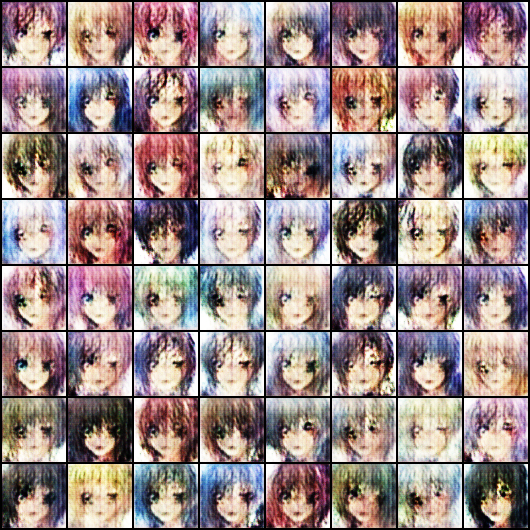

In [57]:
Image('./generated/generated-images-0200.png')

making all the output images as a video file

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

ploting the losses


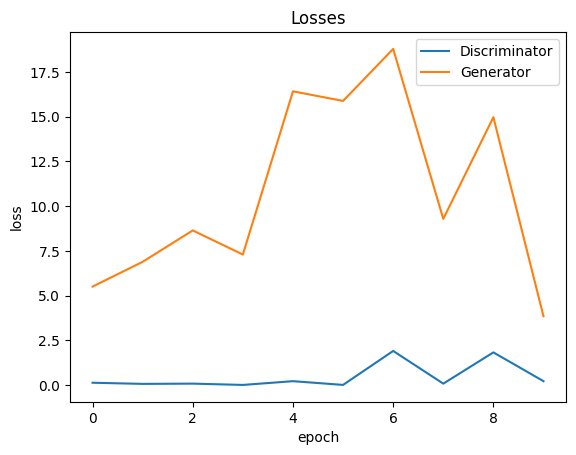

In [47]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

ploting the scores

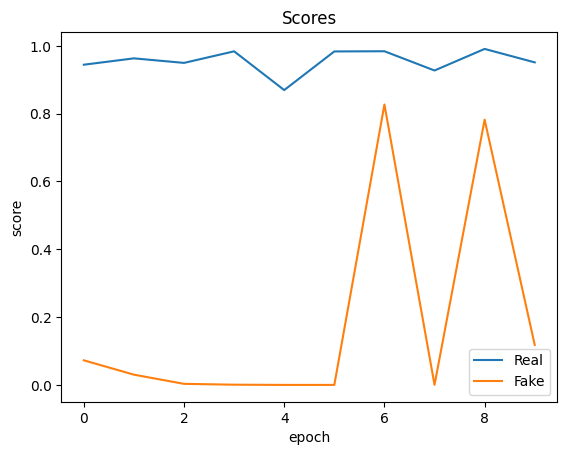

In [48]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');